In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score


In [60]:
import pandas as pd
df = pd.read_csv('tsa_train.csv')
df = df.sort_values('Date')
print(f"Data Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total Days: {len(df)}")
df.head() # to display the first 5 lines of loaded data

Data Range: 2022-01-01 to 2025-07-01
Total Days: 1278


,Date,Volume
0,2022-01-01,1616850.0
1,2022-01-02,2026176.0
2,2022-01-03,1921966.0
3,2022-01-04,1673499.0
4,2022-01-05,1501170.0


In [61]:
from pandas.tseries.holiday import USFederalHolidayCalendar

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df['Date'].min(), end=test_df['Date'].max())

holidays_set = set(holidays.date)

def is_holiday_func(date):
    return int(date.date() in holidays_set)

In [62]:
df['year'] = df['Date'].str.split('-').str[0].astype(int)
df['month'] = df['Date'].str.split('-').str[1].astype(int)
df['day'] = df['Date'].str.split('-').str[2].astype(int)
df['day_of_week'] = pd.to_datetime(df['Date']).dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_year'] = df['Date'].dt.dayofyear
df['quarter'] = df['Date'].dt.quarter
df['is_holiday'] = df['Date'].apply(is_holiday_func)
features = df.columns.tolist()
features.remove('Date')
features.remove('Volume')
df.head()

,Date,Volume,year,month,day,day_of_week,is_weekend,day_of_year,quarter,is_holiday
0,2022-01-01,1616850.0,2022,1,1,5,1,1,1,0
1,2022-01-02,2026176.0,2022,1,2,6,1,2,1,0
2,2022-01-03,1921966.0,2022,1,3,0,0,3,1,0
3,2022-01-04,1673499.0,2022,1,4,1,0,4,1,0
4,2022-01-05,1501170.0,2022,1,5,2,0,5,1,0


In [63]:
class GradientBoostingRegressor:

  def __init__(self, lr=0.01, n_estimators=2000, base_learner=DecisionTreeRegressor):
    self.lr = lr
    self.n_estimators = n_estimators
    self.base_learner = base_learner

  def fit(self, X, y, **params):
    self.base_models = []

    f0 = np.full(shape=y.shape, fill_value=0.0)

    Fm = f0

    _, axs = plt.subplots(5, 4, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(0, self.n_estimators):
      r_i = y - Fm

      h_i = self.base_learner(**params)
      h_i.fit(X, r_i)
      self.base_models.append(h_i)

      Fm = Fm + self.lr*h_i.predict(X)

      if i % 100 == 0:
        axs[i // 100].plot(y, ".")
        axs[i // 100].plot(Fm, ".")
        axs[i // 100].set_title(str(i))
        axs[i // 100].axis("off")

    plt.show()

    return Fm

  def predict(self, X):
    y_pred = np.array([])

    for h_i in self.base_models:
      update = self.lr*h_i.predict(X)
      y_pred = update if not y_pred.any() else y_pred + update

    return y_pred

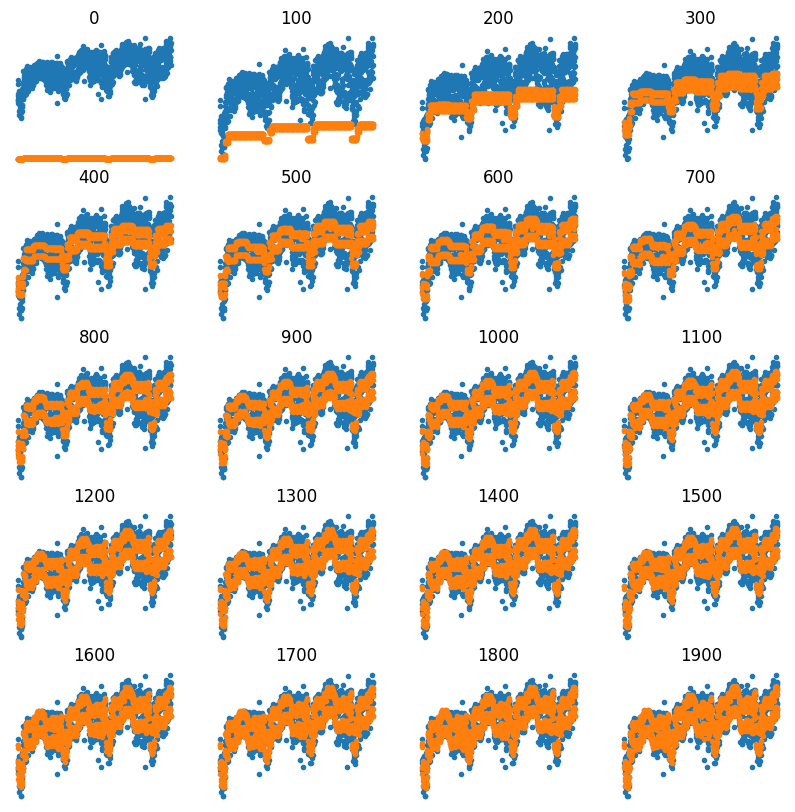

In [64]:
X = df[features]
y = df['Volume']

model = GradientBoostingRegressor()
r = model.fit(X, y, max_depth=2)

In [65]:
test_df = pd.read_csv('tsa_test.csv')
test_df = test_df.sort_values('Date')
test_df['year'] = test_df['Date'].str.split('-').str[0].astype(int)
test_df['month'] = test_df['Date'].str.split('-').str[1].astype(int)
test_df['day'] = test_df['Date'].str.split('-').str[2].astype(int)
test_df['day_of_week'] = pd.to_datetime(test_df['Date']).dt.dayofweek
test_df['is_weekend'] = test_df['day_of_week'].isin([5, 6]).astype(int)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['day_of_year'] = test_df['Date'].dt.dayofyear
test_df['quarter'] = test_df['Date'].dt.quarter
test_df['is_holiday'] = test_df['Date'].apply(is_holiday_func)

test_df.head()

,Date,Volume,year,month,day,day_of_week,is_weekend,day_of_year,quarter,is_holiday
0,2025-07-02,2718537.0,2025,7,2,2,0,183,3,0
1,2025-07-03,2923234.0,2025,7,3,3,0,184,3,0
2,2025-07-04,2162755.0,2025,7,4,4,0,185,3,1
3,2025-07-05,2457591.0,2025,7,5,5,1,186,3,0
4,2025-07-06,3041954.0,2025,7,6,6,1,187,3,0


In [66]:
X_test = test_df[features]
y_test = test_df['Volume']

pred = model.predict(X_test)

score = explained_variance_score(y_test, pred)
print(f"Score: {score}")

Score: 0.7133161852743455


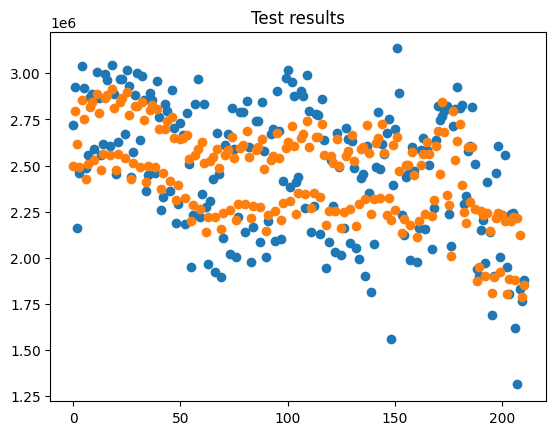

In [67]:
_, ax = plt.subplots(1, 1)
plt.title("Test results")
ax.plot(y_test, "o", label = "y_test")
ax.plot(pred, "o", label = "preds")
ax.legend
plt.show()